In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [4]:
dems = pd.read_csv("../datasets/dem_candidates.csv")

In [5]:
brookings = pd.read_csv("../datasets/brookings.csv")

### How many states were involved in the 2018 primary elections for the House and Senate?

In [6]:
dems["State"].unique() #correct number of states involved without including incumbents

array(['AL', 'AR', 'AZ', 'CA', 'CO', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS',
       'KY', 'MD', 'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NJ',
       'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'WA', 'WV'], dtype=object)

In [7]:
brookings["Candidate.State"].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY',
       'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [8]:
len(brookings), len(dems)

(2280, 811)

In [9]:
brookings = brookings[brookings["Candidate.Party"] == "Democrat"]
brookings = brookings[brookings["Incumbency"] == 0]

In [10]:
len(brookings), len(dems)

(973, 811)

In [11]:
brookings.describe()

,Unnamed: 0,Candidate.District,Incumbency,Female,Democrat,Republican
count,973.000000,973.000000,973.0,973.000000,973.0,973.0
mean,1147.210689,8.892086,0.0,0.329908,1.0,0.0
std,623.668112,10.005845,0.0,0.470421,0.0,0.0
min,1.000000,0.000000,0.0,0.000000,1.0,0.0
25%,642.000000,2.000000,0.0,0.000000,1.0,0.0
50%,1152.000000,5.000000,0.0,0.000000,1.0,0.0
75%,1661.000000,12.000000,0.0,1.000000,1.0,0.0
max,2277.000000,50.000000,0.0,1.000000,1.0,0.0


In [12]:
dems["Candidate"][0:10]

0    Anthony White (Alabama)
1     Christopher Countryman
2      Doug "New Blue" Smith
3            James C. Fields
4              Sue Bell Cobb
5                Walt Maddox
6    Lizzetta Hill McConnell
7         Robert Kennedy Jr.
8       Audri Scott Williams
9              Tabitha Isner
Name: Candidate, dtype: object

### Regularize the name of candidates

In [13]:
def extract_first_last(name):
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\".*?\"', '', name)
    parts = name.split()

    if len(parts) >= 2:
        return parts[0] + ' ' + parts[-1]
    elif len(parts) == 1:
        return parts[0]
    else:
        return ''

dems['Candidate'] = dems['Candidate'].apply(extract_first_last)

dems['Candidate']

0               Anthony White
1      Christopher Countryman
2                  Doug Smith
3                James Fields
4                    Sue Cobb
                ...          
806            Talley Sergent
807           Janice Hagerman
808                Paul Davis
809             Richard Ojeda
810              Shirley Love
Name: Candidate, Length: 811, dtype: object

In [14]:
dems['Candidate'] = dems['Candidate'].str.upper()

dems[['Candidate First Name', 'Candidate Last Name']] = dems['Candidate'].str.split(' ', n = 1, expand=True)
dems.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Candidate First Name,Candidate Last Name
0,ANTHONY WHITE,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ANTHONY,WHITE
1,CHRISTOPHER COUNTRYMAN,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHRISTOPHER,COUNTRYMAN
2,DOUG SMITH,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DOUG,SMITH
3,JAMES FIELDS,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,JAMES,FIELDS
4,SUE COBB,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SUE,COBB


In [15]:
brookings['Candidate.First.Name'] = brookings['Candidate.First.Name'].str.upper()
brookings['Candidate.Last.Name'] = brookings['Candidate.Last.Name'].str.upper()

In [16]:
dems_candidates = set(dems['Candidate First Name'] + ' ' + dems['Candidate Last Name'])
brookings_candidates = set(brookings['Candidate.First.Name'] + ' ' + brookings['Candidate.Last.Name'])

missing_in_brookings = dems_candidates - brookings_candidates

missing_in_dems = brookings_candidates - dems_candidates

print(f"Candidates in 'dems' but not in 'brookings': {missing_in_brookings}")
print(f"Candidates in 'brookings' but not in 'dems': {missing_in_dems}")

Candidates in 'dems' but not in 'brookings': {'COLEMAN II', 'SID ZELLER', 'ANDREW KIM', 'JOSH WELLE', 'RICK TREVI̱O', 'TYLER DAVIS', 'ADAM COTE', 'RICHARD CORDRAY', 'LUCAS CLAIR', 'JOSEPH SCHIAVONI', 'JOE HOEFFEL', 'JOHN CHIANG', 'LIUBA SHIRLEY', 'STACEY EVANS', 'M.J. HEGAR', 'PETER DILL', 'WILL III', 'DANIEL BURLEIGH', 'BILL HOPKINS', 'DAVID JONES', 'THOMAS CARES', 'ROBERT GRIFFIS', 'MARTIN OLSEN', 'JOHN NORRIS', 'DIANE RUSSELL', 'JANET MILLS', 'ROSS WILBURN', 'JACK BERGESON', 'GAVIN NEWSOM', "RONALD O'DONNELL", 'TODD ALLEN', 'KLEMENT TINAJ', 'BEN JEALOUS', 'JIM CRARY', 'TAWANA CADIEN', 'FRED HUBBELL', 'DANIEL CANON', 'NATE BOULTON', 'GRADY YARBROUGH', 'DENISE ADAMS', 'LIZZETTA MCCONNELL', 'ANDY MCGUIRE', 'DONNA DION', 'TIMOTHY WHITE', 'BILL HAAS', 'BOB DAIBER', 'TJ MULLOY', 'LETICIA SANDERS', 'STEVE SISOLAK', 'CAROLYN BOURDEAUX', 'MEZIANNE PAYNE', 'JEFFREY PAYNE', 'JIM SHEA', 'J.B. PRITZKER', 'STEVE LOUGH', 'MICHAEL JOHNSTON', 'CHRISSY HOULAHAN', 'JOHN ROBERSON', 'CRAIG FITZHUGH', 'C

### Merge the datasets

*I did an inner and outer merge, but I opted to keep the inner-merged dataset for the sake of having sufficient enough data and not having too many* `NaN` *entries.*

In [17]:
dems['Candidate First Name'] = dems['Candidate First Name'].str.upper()
dems['Candidate Last Name'] = dems['Candidate Last Name'].str.upper()
brookings['Candidate.First.Name'] = brookings['Candidate.First.Name'].str.upper()
brookings['Candidate.Last.Name'] = brookings['Candidate.Last.Name'].str.upper()

#outer merge (combine the datasets even if candidates not present in both
merged_df = pd.merge(dems, brookings, 
                     left_on=['Candidate First Name', 'Candidate Last Name'], 
                     right_on=['Candidate.First.Name', 'Candidate.Last.Name'], 
                     how='outer')

In [18]:
merged_df.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Republican,Trump.Mention,Obama.Mention,Sanders.Mention,Clinton.Mention,Special.Counsel.Mention,Travel.Ban.Mention,SinglePayer,Primary.Outcome,Primary.Runoff.Outcome
0,ANTHONY WHITE,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHRISTOPHER COUNTRYMAN,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOUG SMITH,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JAMES FIELDS,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SUE COBB,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def fill_candidate(row):
    if pd.isna(row['Candidate']):
        if not pd.isna(row['Candidate.First.Name']) and not pd.isna(row['Candidate.Last.Name']):
            return row['Candidate.First.Name'] + ' ' + row['Candidate.Last.Name']
    return row['Candidate']

merged_df['Candidate'] = merged_df.apply(fill_candidate, axis=1)

def fill_first_last_names(row):
    if pd.isna(row['Candidate.First.Name']) or pd.isna(row['Candidate.Last.Name']):
        if not pd.isna(row['Candidate']):
            names = row['Candidate'].split(' ', 1)
            if len(names) == 2:
                row['Candidate.First.Name'], row['Candidate.Last.Name'] = names
            elif len(names) == 1:
                row['Candidate.First.Name'] = names[0]
                row['Candidate.Last.Name'] = ''
    return row

merged_df = merged_df.apply(fill_first_last_names, axis=1)

merged_df.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Republican,Trump.Mention,Obama.Mention,Sanders.Mention,Clinton.Mention,Special.Counsel.Mention,Travel.Ban.Mention,SinglePayer,Primary.Outcome,Primary.Runoff.Outcome
0,ANTHONY WHITE,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHRISTOPHER COUNTRYMAN,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DOUG SMITH,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
merged_df.columns

Index(['Candidate', 'State', 'District', 'Office Type', 'Race Type',
       'Race Primary Election Date', 'Primary Status', 'Primary Runoff Status',
       'General Status', 'Partisan Lean', 'Primary %', 'Won Primary', 'Race',
       'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?',
       'Obama Alum?', 'Party Support?', 'Emily Endorsed?',
       'Guns Sense Candidate?', 'Biden Endorsed?', 'Warren Endorsed? ',
       'Sanders Endorsed?', 'Our Revolution Endorsed?',
       'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?',
       'WFP Endorsed?', 'VoteVets Endorsed?', 'No Labels Support?',
       'Candidate First Name', 'Candidate Last Name', 'Unnamed: 0',
       'Candidate.First.Name', 'Candidate.Last.Name', 'Candidate.State',
       'Candidate.District', 'Candidate.Party', 'Incumbent', 'Freshman.Member',
       'Candidate.Website.URL', 'Candidate.Gender', 'Listed.military.service.',
       'Education', 'Marital.Status', 'Previous.Electoral.Experien

**nasty.**

In [21]:
#inner merged dataset (include only entries present in both datasets
inner_merged_df = pd.merge(dems, brookings, 
                           left_on=['Candidate First Name', 'Candidate Last Name'], 
                           right_on=['Candidate.First.Name', 'Candidate.Last.Name'], 
                           how='inner')

inner_merged_df.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Republican,Trump.Mention,Obama.Mention,Sanders.Mention,Clinton.Mention,Special.Counsel.Mention,Travel.Ban.Mention,SinglePayer,Primary.Outcome,Primary.Runoff.Outcome
0,AUDRI WILLIAMS,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,0,NEGATIVE MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,"Yes, candidate supports universal healthcare r...",Loser,NaN
1,TABITHA ISNER,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.080002,...,0,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,"Yes, candidate supports universal healthcare r...",Winner,NaN
2,ADIA WINFREY,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,None,None,-33.660000,...,0,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NO MENTION,NaN,Loser,NaN


**Inner merge is much more wholesome.**

### Inner merge FEC data onto Brookings-FiveThirtyEight

In [34]:
fec = pd.read_csv("../datasets/fec-house.csv")
fec["name"][0:10]

0          SEWELL, TERRI A.
1             BERA, AMERISH
2          DESAULNIER, MARK
3           GARAMENDI, JOHN
4              SCHIFF, ADAM
5                 CHU, JUDY
6               BASS, KAREN
7            DAVIS, SUSAN A
8           DELAURO, ROSA L
9    NORTON, ELEANOR HOLMES
Name: name, dtype: object

In [35]:
def extract_and_reorder_name(name):
    parts = name.split()[:2] 
    if len(parts) == 2:
        last_name, first_name = parts
        last_name = last_name.replace(',', '')
        return f"{first_name} {last_name}"
    return name  

fec['name'] = fec['name'].apply(extract_and_reorder_name)
fec['name']

0          TERRI SEWELL
1          AMERISH BERA
2       MARK DESAULNIER
3        JOHN GARAMENDI
4           ADAM SCHIFF
             ...       
1568     TALLEY SERGENT
1569      RICHARD OJEDA
1570         PAUL DAVIS
1571     STEVE WILLIAMS
1572       SHIRLEY LOVE
Name: name, Length: 1573, dtype: object

In [37]:
#filter out incumbents
#fec = fec[fec['CAND_ICI'] != 'I']

In [38]:
fec.head()

,name,office,office_full,party,party_full,state,district,district_number,election_districts,election_years,...,party.1,office.1,candidate_inactive.1,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,state.1,district.1,district_number.1,state_full
0,TERRI SEWELL,H,House,DEM,DEMOCRATIC PARTY,AL,7,7,"{07,07,07,07,07,07,07,07}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,314433.51,0.00,1453045.73,AL,7,7,Alabama
1,AMERISH BERA,H,House,DEM,DEMOCRATIC PARTY,CA,7,7,"{03,07,07,07,07,07,06,06}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,1463699.25,0.00,1193555.00,CA,7,7,California
2,MARK DESAULNIER,H,House,DEM,DEMOCRATIC PARTY,CA,11,11,"{10,11,11,11,11,10,10}","{2010,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,177938.55,0.00,344100.00,CA,11,11,California
3,JOHN GARAMENDI,H,House,DEM,DEMOCRATIC PARTY,CA,3,3,"{10,03,03,03,03,03,08,08}","{2010,2012,2014,2016,2018,2020,2022,2024}",...,DEM,H,f,346985.92,0.00,712960.30,CA,3,3,California
4,ADAM SCHIFF,H,House,DEM,DEMOCRATIC PARTY,CA,28,28,"{27,29,29,29,29,29,28,28,28,28,28,30,30}","{2000,2002,2004,2006,2008,2010,2012,2014,2016,...",...,DEM,H,f,2955743.08,722929.86,566750.00,CA,28,28,California


In [40]:
merged_final_df = pd.merge(inner_merged_df, fec, 
                           left_on='Candidate', 
                           right_on='name', 
                           how='inner')
merged_final_df.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,party.1,office.1,candidate_inactive.1,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,state.1,district.1,district_number.1,state_full
0,AUDRI WILLIAMS,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,DEM,H,f,26117.00,0.0,0.0,AL,2,2,Alabama
1,TABITHA ISNER,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.080002,...,DEM,H,f,305482.95,0.0,8605.0,AL,2,2,Alabama
2,ADIA WINFREY,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,None,None,-33.660000,...,DEM,H,f,2765.00,0.0,0.0,AL,3,3,Alabama


✨*beautiful*✨

In [41]:
merged_final_df["State"].unique()

array(['AL', 'AR', 'AZ', 'CA', 'CO', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS',
       'WV', 'KY', 'MD', 'ME', 'MI', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'WA'], dtype=object)

In [44]:
merged_final_df.columns.tolist()

['Candidate',
 'State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'Primary Status',
 'Primary Runoff Status',
 'General Status',
 'Partisan Lean',
 'Primary %',
 'Won Primary',
 'Race',
 'Veteran?',
 'LGBTQ?',
 'Elected Official?',
 'Self-Funder?',
 'STEM?',
 'Obama Alum?',
 'Party Support?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?',
 'Candidate First Name',
 'Candidate Last Name',
 'Unnamed: 0',
 'Candidate.First.Name',
 'Candidate.Last.Name',
 'Candidate.State',
 'Candidate.District',
 'Candidate.Party',
 'Incumbent',
 'Freshman.Member',
 'Candidate.Website.URL',
 'Candidate.Gender',
 'Listed.military.service.',
 'Education',
 'Marital.Status',
 'Previous.Electoral.Experience',
 'Position.on.Affordable.Care.Act..ObamaCare.

In [47]:
merged_final_df[['receipts', 'individual_itemized_contributions', 'transfers_from_other_authorized_committee', 'other_political_committee_contributions']]

,receipts,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions
0,35365.02,26117.00,0.00,0.00
1,524941.35,305482.95,0.00,8605.00
2,14535.25,2765.00,0.00,0.00
3,467514.71,215160.38,0.00,30500.00
4,590173.38,417234.37,0.00,29823.41
...,...,...,...,...
506,588749.56,335421.20,125657.35,11794.18
507,705197.45,482999.50,14067.96,90850.00
508,0.00,0.00,0.00,0.00
509,2851527.56,1541326.99,109779.32,429886.46


In [43]:
merged_final_df.describe()

,Partisan Lean,Primary %,Unnamed: 0,Candidate.District,Incumbency,Female,Democrat,Republican,district,district_number,...,cycle,receipts,disbursements,cash_on_hand_end_period,debts_owed_by_committee,individual_itemized_contributions,transfers_from_other_authorized_committee,other_political_committee_contributions,district.1,district_number.1
count,511.000000,502.000000,511.000000,511.000000,511.0,511.000000,511.0,511.0,511.000000,511.000000,...,511.0,5.110000e+02,5.110000e+02,511.000000,5.110000e+02,5.110000e+02,5.110000e+02,511.0000,511.000000,511.000000
mean,-14.816419,30.995040,1262.354207,9.953033,0.0,0.375734,1.0,0.0,9.949119,9.949119,...,2018.0,8.210754e+05,8.092960e+05,12062.937984,2.106005e+04,4.494152e+05,3.891450e+04,58492.2409,9.949119,9.949119
std,21.382698,26.330910,600.266446,10.299712,0.0,0.484786,0.0,0.0,10.316432,10.316432,...,0.0,1.799297e+06,1.779477e+06,40817.666597,8.747677e+04,9.701694e+05,1.440210e+05,147460.7325,10.316432,10.316432
min,-62.060001,0.830000,11.000000,1.000000,0.0,0.000000,1.0,0.0,0.000000,0.000000,...,2018.0,0.000000e+00,0.000000e+00,-24440.880000,-7.650000e+02,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000
25%,-28.759999,10.442500,754.000000,3.000000,0.0,0.000000,1.0,0.0,3.000000,3.000000,...,2018.0,1.522411e+04,1.414388e+04,0.000000,0.000000e+00,3.975000e+03,0.000000e+00,0.0000,3.000000,3.000000
50%,-15.510000,23.765000,1366.000000,6.000000,0.0,0.000000,1.0,0.0,6.000000,6.000000,...,2018.0,1.122397e+05,1.096503e+05,19.710000,0.000000e+00,5.045626e+04,0.000000e+00,250.0000,6.000000,6.000000
75%,-4.980000,41.282499,1756.500000,13.000000,0.0,1.000000,1.0,0.0,13.000000,13.000000,...,2018.0,6.540169e+05,6.504894e+05,4647.250000,3.050000e+03,3.370269e+05,0.000000e+00,14875.0000,13.000000,13.000000
max,65.089996,100.000000,2261.000000,50.000000,0.0,1.000000,1.0,0.0,50.000000,50.000000,...,2018.0,1.846837e+07,1.835983e+07,558059.470000,1.179500e+06,6.733490e+06,1.173401e+06,877796.3100,50.000000,50.000000


In [28]:
len(merged_final_df)

450

### Selecting features of significance

At this point, there were 112 total present columns (nasty) and we only want a select few. I cherry-picked the ones below.

In [29]:
filtered_columns = [
    "Candidate", "State", "District", "Office Type", "Race Type", 
    "Race Primary Election Date", "Primary Status", "General Status",
    "CAND_CONTRIB", "OTHER_POL_CMTE_CONTRIB", "POL_PTY_CONTRIB", 
    "INDIV_REFUNDS", "CMTE_REFUNDS", "CVG_END_DT"
]

endorsement_columns = [col for col in merged_final_df.columns if 'Endorsed' in col]
filtered_columns.extend(endorsement_columns)

merged_final_df = merged_final_df[filtered_columns]

In [49]:
merged_final_df.columns.to_list()

['Candidate',
 'State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'Primary Status',
 'Primary Runoff Status',
 'General Status',
 'Partisan Lean',
 'Primary %',
 'Won Primary',
 'Race',
 'Veteran?',
 'LGBTQ?',
 'Elected Official?',
 'Self-Funder?',
 'STEM?',
 'Obama Alum?',
 'Party Support?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?',
 'Candidate First Name',
 'Candidate Last Name',
 'Unnamed: 0',
 'Candidate.First.Name',
 'Candidate.Last.Name',
 'Candidate.State',
 'Candidate.District',
 'Candidate.Party',
 'Incumbent',
 'Freshman.Member',
 'Candidate.Website.URL',
 'Candidate.Gender',
 'Listed.military.service.',
 'Education',
 'Marital.Status',
 'Previous.Electoral.Experience',
 'Position.on.Affordable.Care.Act..ObamaCare.

In [31]:
merged_final_df.head(3)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,General Status,CAND_CONTRIB,OTHER_POL_CMTE_CONTRIB,...,Emily Endorsed?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?
0,AUDRI WILLIAMS,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,NaN,2200.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TABITHA ISNER,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,On the Ballot,14285.73,8605.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADIA WINFREY,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,NaN,140.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
merged_final_df["Biden Endorsed?"].unique() #sanity check

array([nan, 'No', 'Yes'], dtype=object)

## Summary of Brookings-FiveThirtyEight-FEC Dataset

**Candidate:** The name of the candidate.

**State:** The state where the candidate is running.

**District:** The specific district for House candidates.

**Office Type:** Whether the candidate is running for Senate, House, or Governor.

**Race Type:** Type of race (e.g., regular, special).

**Race Primary Election Date:** The date of the primary election.

**Primary Status:** Whether the candidate won or lost the primary.

**General Status:** The candidate's status in the general election.

**INDIV_CONTRIB:** Individual contributions.

**CAND_CONTRIB:** Candidate contributions.

**OTHER_POL_CMTE_CONTRIB:** Other political committee contributions.

**POL_PTY_CONTRIB:** Political party contributions.

**INDIV_REFUNDS:** Refunds to individuals.

**MTE_REFUNDS:** Refunds to committees.

**GEN_ELECTION:** Indicates if the candidate reached the general election.

**GEN_ELECTION_PRECENT:** The percentage of votes in the general election.

*As well as columns related to **endorsements** by various political entities and figures (e.g.: 'Biden Endorsed?', 'Emily Endorsed?', etc.)*


In [51]:
#merged_final_df.to_csv("demsmerge.csv")

### OHE Categorical Columns

In [52]:
target_variable = 'Primary Status'

categorical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype == 'object' and col != target_variable]
numerical_columns = [col for col in merged_final_df.columns if merged_final_df[col].dtype != 'object' and col != target_variable]

#One-Hot Encoding to categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(merged_final_df[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns)
df_prepared = pd.concat([merged_final_df[numerical_columns], df_encoded], axis=1)

#extract the target variable
y = merged_final_df[target_variable].apply(lambda x: 1 if x == 'Advanced' else 0) # Assuming 'Advanced' means success

# The GLM using Logistic Regression

I naively selected logistic reg. since the target variable is whether or not the candidate makes it past the primaries.

We are modeling in the ✨ Frequentist Perspective ✨

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df_prepared, y, test_size=0.3, random_state=42)

### Random Over-Sampling

In [83]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
glm_model_ros = LogisticRegression(max_iter=1000)

In [84]:
glm_model_ros.fit(X_train_ros, y_train_ros)
y_pred_ros = glm_model_ros.predict(X_test)

In [85]:
report_ros = classification_report(y_test, y_pred_ros)
conf_matrix_ros = confusion_matrix(y_test, y_pred_ros)

In [86]:
print("Report with ROS:", report_ros)

Report with ROS:               precision    recall  f1-score   support

           0       0.79      0.95      0.86        80
           1       0.90      0.64      0.74        55

    accuracy                           0.82       135
   macro avg       0.84      0.79      0.80       135
weighted avg       0.83      0.82      0.82       135



In [88]:
print("Confusion Matrix with ROS:")
print(conf_matrix_ros)

Confusion Matrix with ROS:
[[76  4]
 [20 35]]


### Random Under-Sampling

In [89]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
glm_model_rus = LogisticRegression(max_iter=1000)

In [90]:
glm_model_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = glm_model_rus.predict(X_test)

In [91]:
report_rus = classification_report(y_test, y_pred_rus)
conf_matrix_rus = confusion_matrix(y_test, y_pred_rus)

In [92]:
print("Report with RUS:", report_rus)

Report with RUS:               precision    recall  f1-score   support

           0       0.93      0.96      0.94        80
           1       0.94      0.89      0.92        55

    accuracy                           0.93       135
   macro avg       0.94      0.93      0.93       135
weighted avg       0.93      0.93      0.93       135



In [93]:
print("Confusion Matrix with RUS:")
print(conf_matrix_rus)

Confusion Matrix with RUS:
[[77  3]
 [ 6 49]]


### Cross-Validation for Random Over & Under-Sampling

In [80]:
cv_scores_ros = cross_val_score(glm_model_ros, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_mean_ros = np.mean(cv_scores_ros)
cv_scores_rus = cross_val_score(glm_model_rus, X_train_rus, y_train_rus, cv=5, scoring='accuracy')
cv_mean_rus = np.mean(cv_scores_rus)
print("CV Mean Accuracy with ROS:", cv_mean_ros)
print("CV Mean Accuracy with RUS:", cv_mean_rus)

CV Mean Accuracy with ROS: 0.9392982456140351
CV Mean Accuracy with RUS: 0.956313725490196


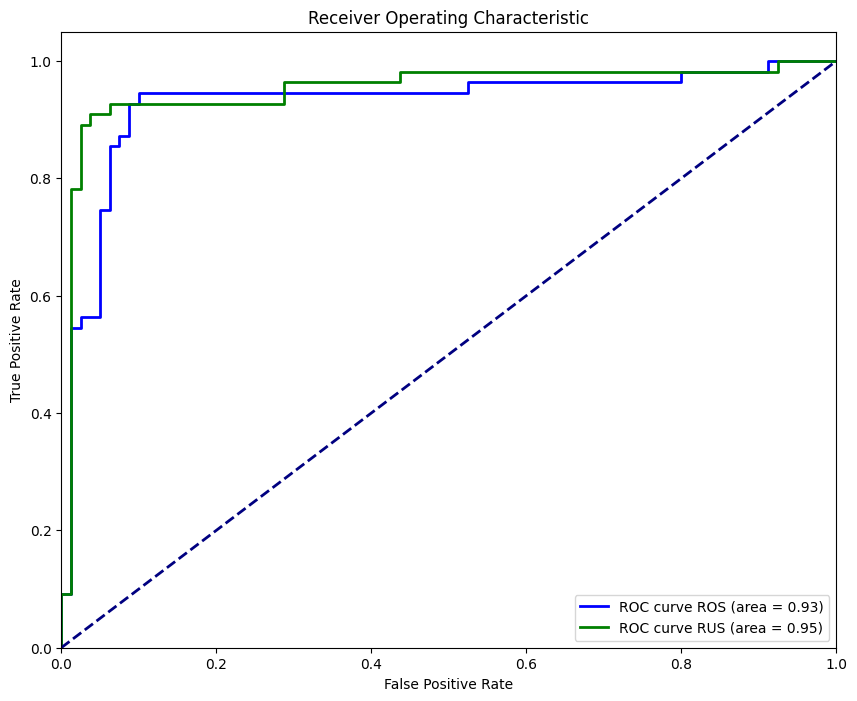

In [98]:
# ROC and AUC for over sampling
fpr_ros, tpr_ros, _ = roc_curve(y_test, glm_model_ros.predict_proba(X_test)[:, 1])
roc_auc_ros = auc(fpr_ros, tpr_ros)

# ROC and AUC for under sampling
fpr_rus, tpr_rus, _ = roc_curve(y_test, glm_model_rus.predict_proba(X_test)[:, 1])
roc_auc_rus = auc(fpr_rus, tpr_rus)

plt.figure(figsize=(10, 8))
plt.plot(fpr_ros, tpr_ros, color='blue', lw=2, label='ROC curve ROS (area = %0.2f)' % roc_auc_ros)
plt.plot(fpr_rus, tpr_rus, color='green', lw=2, label='ROC curve RUS (area = %0.2f)' % roc_auc_rus)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Let's make a ✨ Decision Tree ✨

**Goal:** Predicting the `Primary Status` of a democratic candidate

The features selected for the Decision Tree model:

- State and District information: Providing geographical context which might influence primary outcomes.
  
- Office and Race Type: Indicating the type of political race, which could have differing and success factors.
  
- Financial Contributions (such as `CAND_CONTRIB`, `OTHER_POL_CMTE_CONTRIB`): Reflecting the financial strength and support for the campaign
  
- Endorsements (like `Emily Endorsed?`)

In [55]:
'''
features for decision tree model
NOTE: remove the 'General Status'
'''
decision_tree_features = merged_final_df.drop(columns=['Primary Status', 'Candidate', 'General Status']).columns.tolist()
decision_tree_features

['State',
 'District',
 'Office Type',
 'Race Type',
 'Race Primary Election Date',
 'CAND_CONTRIB',
 'OTHER_POL_CMTE_CONTRIB',
 'POL_PTY_CONTRIB',
 'INDIV_REFUNDS',
 'CMTE_REFUNDS',
 'CVG_END_DT',
 'Emily Endorsed?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?']

In [56]:
#features and target variable
X = merged_final_df[decision_tree_features]  
y = merged_final_df['Primary Status'].apply(lambda x: 1 if x == 'Advanced' else 0)  

In [57]:
#OHE
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
X_ohe = pd.get_dummies(X[categorical_columns])
X_prepared = pd.concat([X.drop(columns=categorical_columns), X_ohe], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.3, random_state=42)

### Random Over-Sampling

In [59]:
ros = RandomOverSampler(random_state=42)
decision_tree_model_ros = DecisionTreeClassifier(random_state=42)

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#for cross validation
pipeline_ros = Pipeline([
    ('oversample', ros),
    ('model', decision_tree_model_ros)
])

In [69]:
decision_tree_model_ros.fit(X_train_ros, y_train_ros)

y_pred_ros = decision_tree_model_ros.predict(X_test)
accuracy_ros = accuracy_score(y_test, y_pred_ros)
class_report_ros = classification_report(y_test, y_pred_ros)

print(accuracy_ros)
print(class_report_ros)

0.8222222222222222
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        80
           1       0.77      0.80      0.79        55

    accuracy                           0.82       135
   macro avg       0.82      0.82      0.82       135
weighted avg       0.82      0.82      0.82       135



In [61]:
feature_importance_ros = decision_tree_model_ros.feature_importances_
feature_importance_ros_df = pd.DataFrame({
    'Feature': X_prepared.columns,
    'Importance': feature_importance_ros
}).sort_values(by='Importance', ascending=False).head(5)

feature_importance_ros_df.head(5)

,Feature,Importance
1,OTHER_POL_CMTE_CONTRIB,0.373005
3,INDIV_REFUNDS,0.131983
2,POL_PTY_CONTRIB,0.118178
332,CVG_END_DT_12/31/2018,0.043971
4,CMTE_REFUNDS,0.027237


### Random Under-Sampling

In [62]:
rus = RandomUnderSampler(random_state=42)
decision_tree_model_rus = DecisionTreeClassifier(random_state=42)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

#for cross validation
pipeline_rus = Pipeline([
    ('oversample', rus),
    ('model', decision_tree_model_rus)
])

In [63]:
decision_tree_model_rus.fit(X_train_rus, y_train_rus)

y_pred_rus = decision_tree_model_rus.predict(X_test)
accuracy_rus = accuracy_score(y_test, y_pred_rus)
class_report_rus = classification_report(y_test, y_pred_rus)

print(accuracy_rus)
print(class_report_rus)

0.8
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        80
           1       0.73      0.80      0.77        55

    accuracy                           0.80       135
   macro avg       0.79      0.80      0.80       135
weighted avg       0.80      0.80      0.80       135



In [64]:
feature_importance_rus = decision_tree_model_rus.feature_importances_
feature_importance_rus_df = pd.DataFrame({
    'Feature': X_prepared.columns,
    'Importance': feature_importance_rus
}).sort_values(by='Importance', ascending=False).head(5)

feature_importance_rus_df.head(5)

,Feature,Importance
1,OTHER_POL_CMTE_CONTRIB,0.383762
2,POL_PTY_CONTRIB,0.138667
3,INDIV_REFUNDS,0.137833
0,CAND_CONTRIB,0.050400
343,Justice Dems Endorsed?_No,0.036783


### Cross-Validation

In [65]:
#cv - over sampling
cv_scores_ros = cross_val_score(pipeline_ros, X_prepared, y, cv=5, scoring='accuracy')
cv_mean_ros = np.mean(cv_scores_ros)

#cv - under sampling
cv_scores_rus = cross_val_score(pipeline_rus, X_prepared, y, cv=5, scoring='accuracy')
cv_mean_rus = np.mean(cv_scores_rus)

(0.8111111111111111, 0.788888888888889)

In [70]:
cv_mean_ros, cv_scores_ros

(0.8111111111111111,
 array([0.91111111, 0.75555556, 0.84444444, 0.8       , 0.74444444]))

In [71]:
cv_mean_rus, cv_scores_rus

(0.788888888888889,
 array([0.86666667, 0.78888889, 0.82222222, 0.75555556, 0.71111111]))

### Visualizations

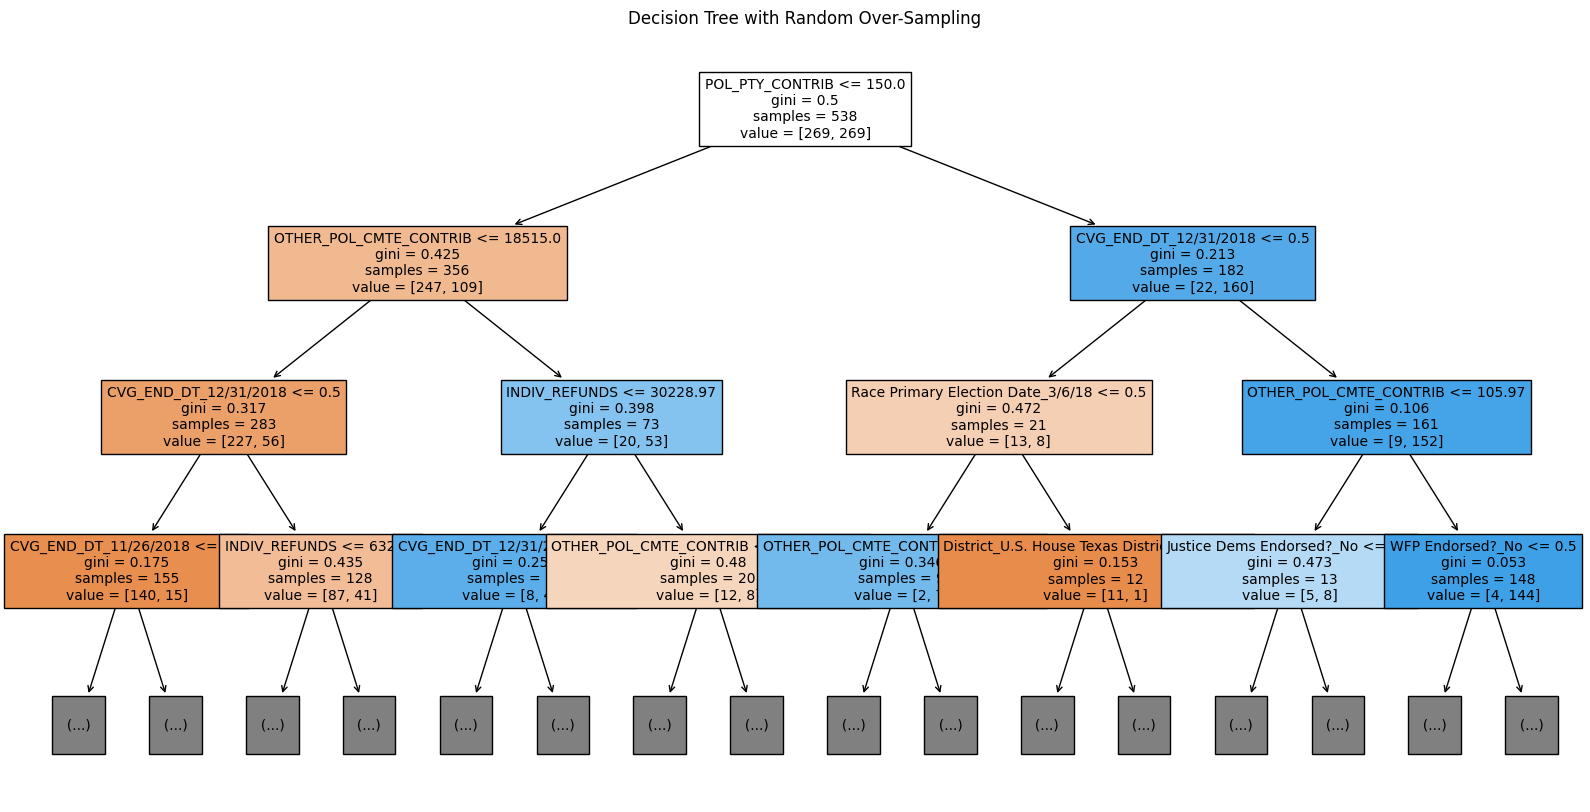

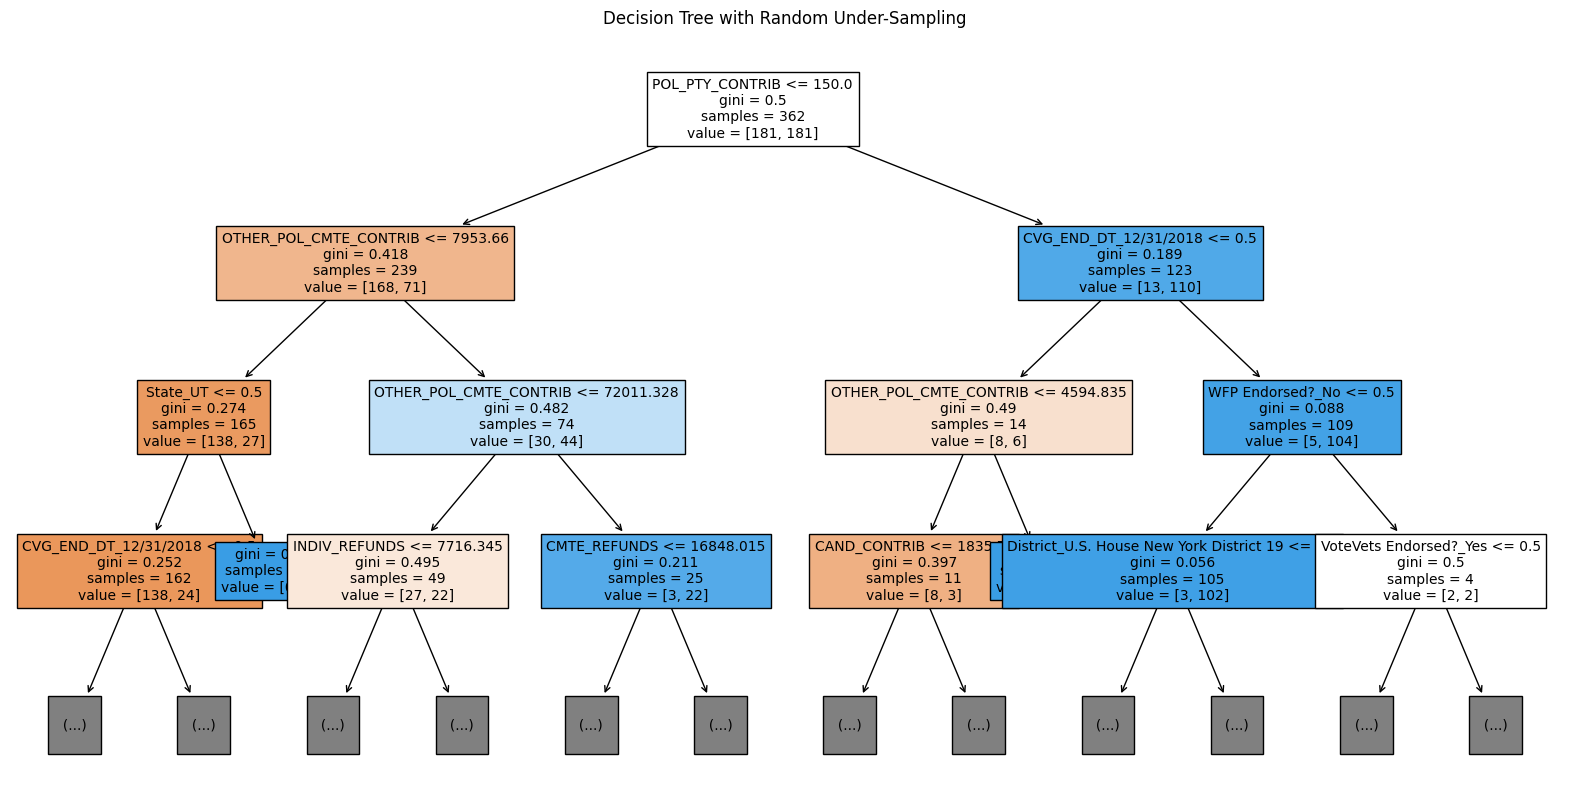

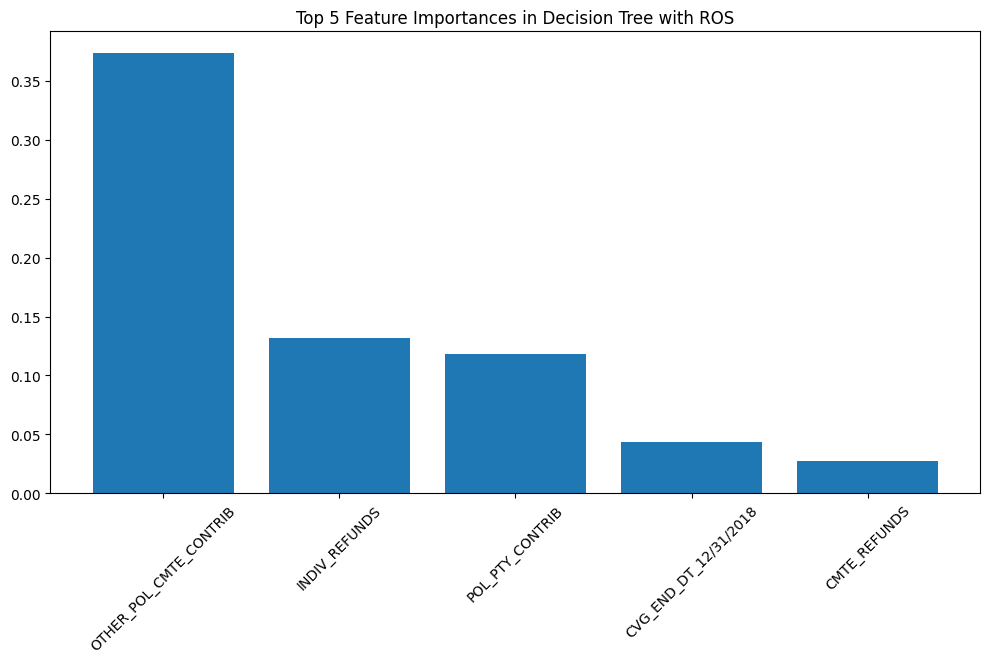

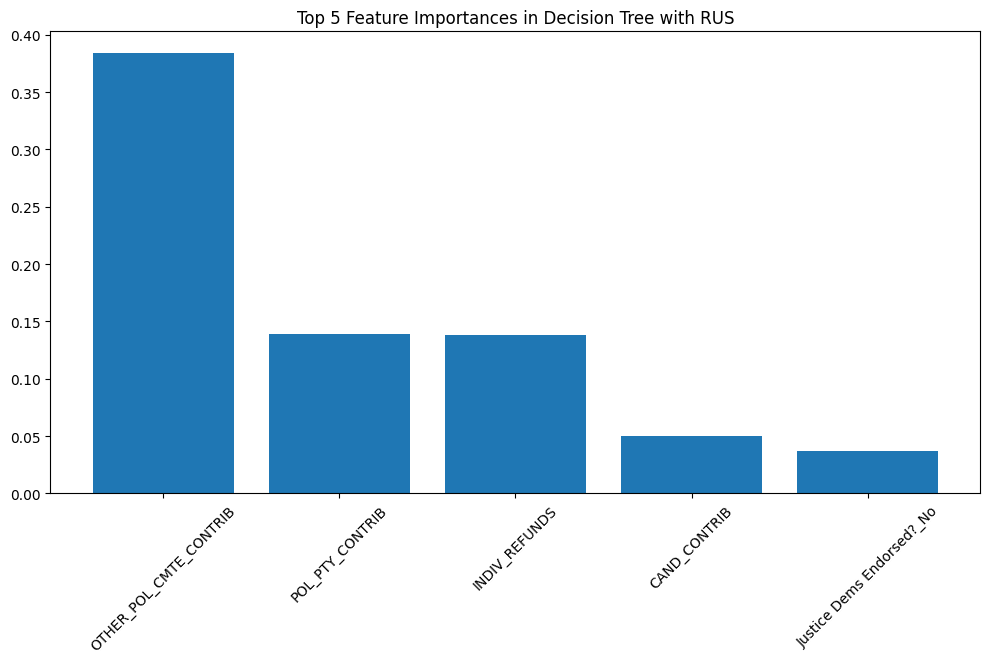

In [68]:
pipeline_ros.fit(X_prepared, y)
model_ros = pipeline_ros.named_steps['model']
pipeline_rus.fit(X_prepared, y)
model_rus = pipeline_rus.named_steps['model']

plt.figure(figsize=(20,10))
plot_tree(model_ros, filled=True, feature_names=X_prepared.columns, max_depth=3, fontsize=10)
plt.title("Decision Tree with Random Over-Sampling")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(model_rus, filled=True, feature_names=X_prepared.columns, max_depth=3, fontsize=10)
plt.title("Decision Tree with Random Under-Sampling")
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Top 5 Feature Importances in Decision Tree with ROS")
plt.bar(feature_importance_ros_df['Feature'], feature_importance_ros_df['Importance'], align="center")
plt.xticks(rotation=45)
plt.show()

# Plotting Top 5 Important Features for Under-Sampling
plt.figure(figsize=(12, 6))
plt.title("Top 5 Feature Importances in Decision Tree with RUS")
plt.bar(feature_importance_rus_df['Feature'], feature_importance_rus_df['Importance'], align="center")
plt.xticks(rotation=45)
plt.show()